In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('train.tsv', sep='\t')

# General informations about the dataset

,category,headline,text,url
0,sports,"L'Ouganda à l'assaut des ""fimbu"" de la RDC","L'Ouganda, placé 79e au classement FIFA le 4 a...",https://www.bbc.com/afrique/sports-48730747
1,business,Stopper la détérioration de l’environnement po...,La responsable de la biodiversité des Nations ...,https://www.bbc.com/afrique/articles/cevdz4xrp42o
2,sports,Coupe d'Afrique des nations 2022 : le sélectio...,"Le sélectionneur de la Sierra Leone, John Keis...",https://www.bbc.com/afrique/region-59881445
3,business,Tissus africains : pourquoi les teintureries h...,"Depuis plus de six siècles, une vaste zone sit...",https://www.bbc.com/afrique/region-61202726
4,business,Les revenus pendant la pandémie des dix hommes...,"Pendant la pandémie de coronavirus, la richess...",https://www.bbc.com/afrique/monde-55812018


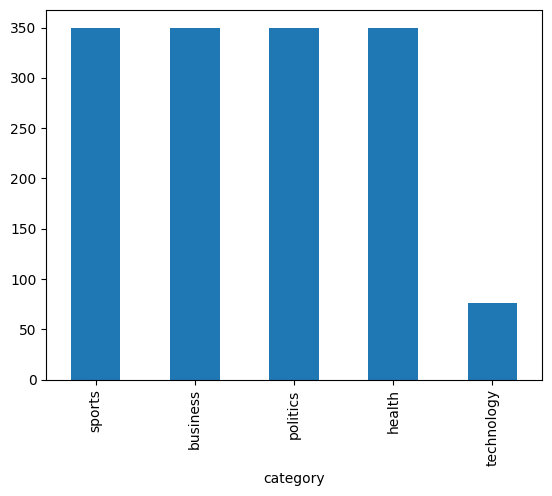

In [5]:
df['category'].value_counts().plot(kind='bar')
df.head()

In [ ]:
# Balancing the dataset by oversampling the minority classes


# ☣️☣️☣️ We did not use this in the best iteration of our model. As it led to a slight decrease in the accuracy of the model ☣️☣️☣️
import random

# Multiply by 4 each line of tech category
aug_df = df.copy()
for i in range(4):
    tech = df[df["category"] == "technology"]
    aug_df = pd.concat([aug_df, tech], ignore_index=True)

# sports        350
# business      350
# politics      350
# health        350
# technology    380

# remove 30 random lines in tech category
for i in range(30):
    aug_df = aug_df.drop(random.choice(aug_df[aug_df["category"] == "technology"].index))


In [ ]:
print(aug_df.keys())
print(aug_df['category'].value_counts())
print(aug_df.head())

## Let's see how the length of the headlines and texts are distributed

array([[<Axes: title={'center': 'business'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'politics'}>,
        <Axes: title={'center': 'sports'}>],
       [<Axes: title={'center': 'technology'}>, <Axes: >]], dtype=object)

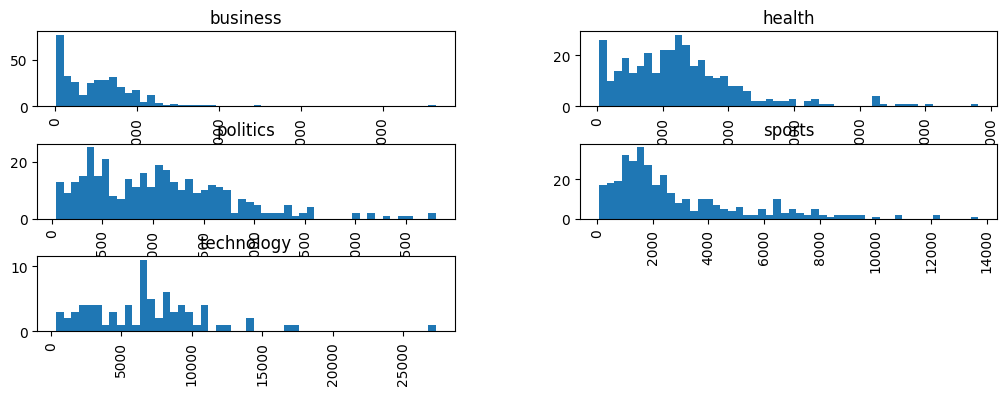

In [6]:
c = "technology"

# plot the length of the headlines for each category
df['length'] = df['text'].apply(len)
df.hist(column='length', by='category', bins=50, figsize=(12, 4))


<Axes: ylabel='Frequency'>

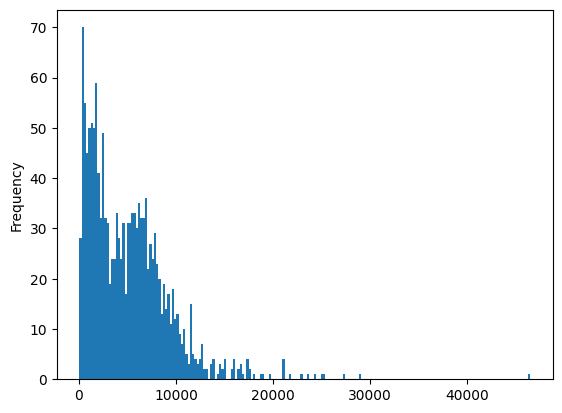

In [ ]:
df["text"].apply(len).plot.hist(bins=200)

### Findings
- Url not relevant, we can drop this column
- Technology is clearly underrepresented in the dataset (1/5 of the support of other categories)
- texts lengths are in the range 0-10_000 characters, very small minority goes up to 40_000 chars. Nothing to worry about here.

We will need to take care of this imbalance in the dataset to avoid bias in the model.

# Vectorizing

In [7]:
X = df[['headline', 'text']]
y = df["category"]

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

SnowballStemmer = nltk.stem.SnowballStemmer

nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("french")

# The articles contain a lot of weird characters, we remove them for simplicity
french_stopwords = stopwords.words("french") + list(string.punctuation) + ["''", "``", "...", "’", "``", "«", "»", "``"]


def tokenize(text):
    tokens = word_tokenize(text, language="french")
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    # stemming
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens


vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=french_stopwords, max_features=1200, lowercase=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dorian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dorian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
tokenize("Ceci est un test de tokenization")

['cec', 'est', 'un', 'test', 'de', 'tokeniz']

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


col_trans = ColumnTransformer(
    [('headline', vectorizer, 'headline'),
        ('text', vectorizer, 'text')
    ])

pipe = make_pipeline(col_trans, LogisticRegression(class_weight='balanced'))

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings


warnings.filterwarnings("ignore")

models = [("Baseline", DummyClassifier(strategy="most_frequent")), ("Multinomial NB", MultinomialNB()), ("CART", DecisionTreeClassifier()), ("LR", LogisticRegression(class_weight="balanced")), ("KNN", KNeighborsClassifier()), ("Random forest", RandomForestClassifier())]
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models:
    pipe = make_pipeline(col_trans, model)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    print(f"{name} : {scores.mean()}")
    print(scores)


Baseline : 0.23577235772357721
[0.23577236 0.23577236 0.23577236]
Multinomial NB : 0.8340108401084011
[0.83536585 0.83130081 0.83536585]
CART : 0.6659891598915989
[0.65650407 0.67276423 0.66869919]
LR : 0.8529810298102981
[0.85365854 0.85569106 0.8495935 ]
KNN : 0.7201897018970188
[0.7601626  0.66869919 0.73170732]
Random forest : 0.8102981029810298
[0.82317073 0.81300813 0.79471545]


## We see that The Logistic Regression model is the best performing model, so we will use it for the final prediction.

In [18]:
# Now we know that logistic regression is the best model, let's see what the confusion matrix looks like
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe = make_pipeline(col_trans, LogisticRegression(class_weight="balanced"))
pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('headline',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=1200,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                              'en',
                                                                              'et',
                                                                              'eux',
                                                                              'il',
                                                                              'ils',
                                                                              'je',
                                                                              'la',
                                                                              'le',
                                                                              'les',
                                                                              'leur',
                                                                              'lui',
                                                                              'ma',
                                                                              'mais',
                                                                              'me',
                                                                              'même',
                                                                              'mes',
                                                                              'moi',
                                                                              'mon',
                                                                              'ne',
                                                                              'nos', ...],
                                                                  tokenizer=<function tokenize at...
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=1200,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                 

In [22]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.78      0.87      0.82        70
      health       0.91      0.89      0.90        70
    politics       0.82      0.89      0.85        70
      sports       0.97      0.86      0.91        70
  technology       0.83      0.62      0.71        16

    accuracy                           0.86       296
   macro avg       0.86      0.82      0.84       296
weighted avg       0.87      0.86      0.86       296



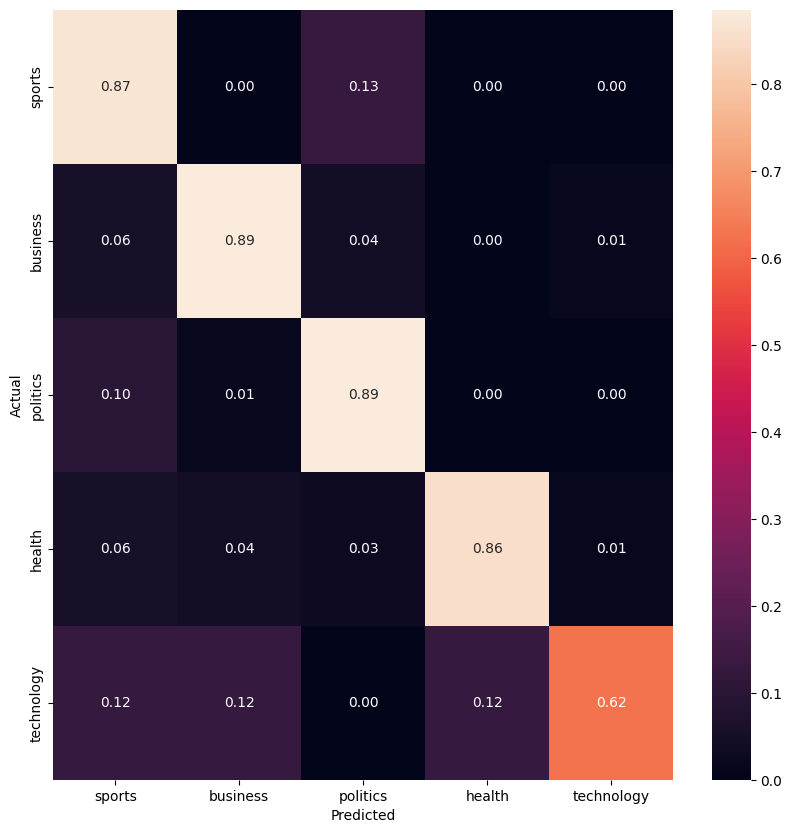

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt=".2f", xticklabels=df["category"].unique(), yticklabels=df["category"].unique())

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


## Let's see if our model top 2 guesses are correct

In [25]:
# Compute accuracy using the 2 top predictions
y_pred_proba = pipe.predict_proba(X_test)
acc = 0
classes = pipe.classes_
for i, pred in enumerate(y_pred_proba):
    top_2 = pred.argsort()[-2:][::-1]
    top_2_classes = [classes[i] for i in top_2]
    actual = y_test.iloc[i]
    if i % 100 == 0:
        print(f"Top 2 classes : {top_2_classes}, actual : {actual}")
    if actual in top_2_classes:
        acc += 1
print(f"Accuracy : {acc/len(y_pred_proba)}")

Top 2 classes : ['health', 'business'], actual : health
Top 2 classes : ['health', 'technology'], actual : health
Top 2 classes : ['sports', 'business'], actual : sports
Accuracy : 0.9662162162162162


It is indeed very good with its first two guesses (97% accuracy). I think we can assume that our model is good bu struggles when the subject is ambiguous aswell as on the technology category.


# Training the final model

In [28]:
# we train the model on the whole training set
pipe = make_pipeline(col_trans, LogisticRegression(class_weight="balanced"))
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('headline',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=1200,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                              'en',
                                                                              'et',
                                                                              'eux',
                                                                              'il',
                                                                              'ils',
                                                                              'je',
                                                                              'la',
                                                                              'le',
                                                                              'les',
                                                                              'leur',
                                                                              'lui',
                                                                              'ma',
                                                                              'mais',
                                                                              'me',
                                                                              'même',
                                                                              'mes',
                                                                              'moi',
                                                                              'mon',
                                                                              'ne',
                                                                              'nos', ...],
                                                                  tokenizer=<function tokenize at...
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=1200,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                 

In [29]:
# Evaluate the performance on the test set
df_test = pd.read_csv('test.tsv', sep='\t')
X_test = df_test[['headline', 'text']]
y_test = df_test["category"]

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.75      0.83      0.79       100
      health       0.91      0.92      0.92       100
    politics       0.86      0.84      0.85       100
      sports       0.96      0.93      0.94       100
  technology       0.87      0.59      0.70        22

    accuracy                           0.86       422
   macro avg       0.87      0.82      0.84       422
weighted avg       0.87      0.86      0.86       422



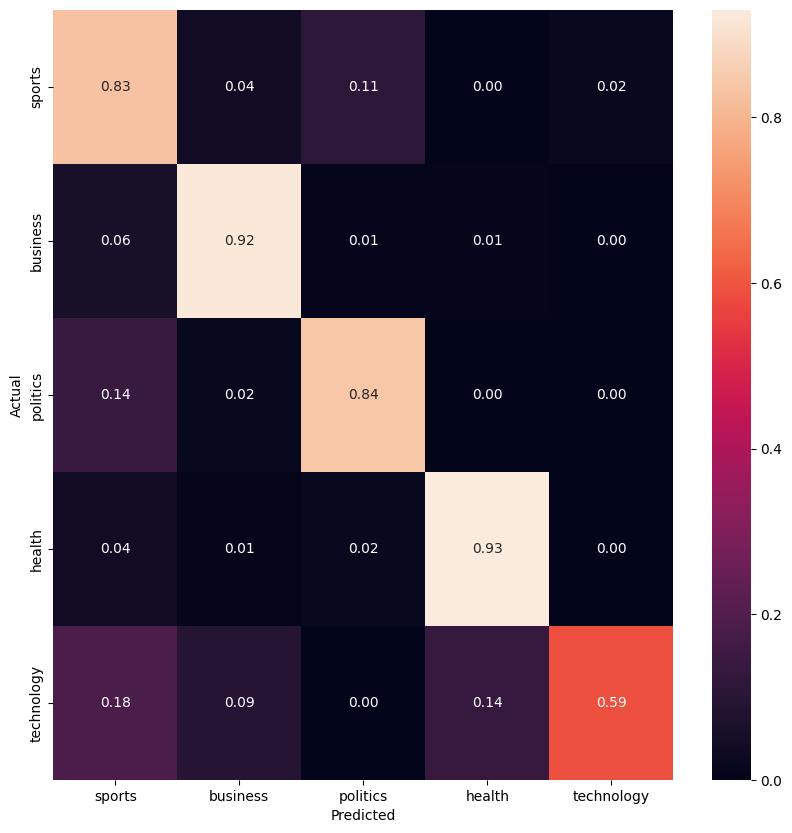

In [30]:
conf_mat = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt=".2f", xticklabels=df["category"].unique(), yticklabels=df["category"].unique())

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()